In [ ]:
!pip install pysam
!pip install crcmod
!apt-get install samtools

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
### picard
!wget https://github.com/broadinstitute/picard/releases/download/2.21.6/picard.jar

### GATK
!wget -O gatk-4.1.4.1.zip "https://github.com/broadinstitute/gatk/releases/download/4.1.4.1/gatk-4.1.4.1.zip"
!unzip gatk-4.1.4.1.zip
!R -e 'install.packages(c("gplots", "gsalib"))'

In [ ]:
#### downloading HG0096.chr20.sorted bam
!gdown --id 1-0U11U1Z3Dp8vLHoZOtagQl25dFdza-C

In [ ]:
!gsutil ls gs://genomics-public-data

!gsutil ls gs://genomics-public-data/resources/broad/hg38/v0

!wget https://storage.googleapis.com/genomics-public-data/resources/broad/hg38/v0/Homo_sapiens_assembly38.fasta

!git clone https://github.com/lh3/bwa.git
!cd bwa && make

In [ ]:
!gsutil cp -r gs://genomics-public-data/resources/broad/hg38/v0 .
!bwa/bwa mem -M -R '@RG\tID:1\tPL:Illumina\tSM:HG00096' -o file.sam {'/content/v0/Homo_sapiens_assembly38.fasta'} {'/content/drive/MyDrive/bioinf/sample_9.chrom11.exome.pe1.fq'} {'/content/drive/MyDrive/bioinf/sample_9.chrom11.exome.pe2.fq'}
!samtools view -b -o file.bam file.sam
!samtools sort -o file.sorted.bam file.bam
!samtools index file.sorted.bam

Copying gs://genomics-public-data/resources/broad/hg38/v0/1000G.phase3.integrated.sites_only.no_MATCHED_REV.hg38.vcf...


KeyboardInterrupt: 

In [ ]:
!gsutil cp -r gs://genomics-public-data/resources/broad/hg38/v0 .
!bwa/bwa mem -M -R '@RG\tID:1\tPL:Illumina\tSM:HG00096' -o file.sam {'/content/v0/Homo_sapiens_assembly38.fasta'} {'/content/drive/MyDrive/bioinf/sample_7.chrom11.exome.pe1.fq'} {'/content/drive/MyDrive/bioinf/sample_7.chrom11.exome.pe2.fq'}
!samtools view -b -o file.bam file.sam
!samtools sort -o file.sorted.bam file.bam
!samtools index file.sorted.bam

Copying gs://genomics-public-data/resources/broad/hg38/v0/1000G.phase3.integrated.sites_only.no_MATCHED_REV.hg38.vcf...
Resuming download for ./v0/1000G.phase3.integrated.sites_only.no_MATCHED_REV.hg38.vcf component 1
Resuming download for ./v0/1000G.phase3.integrated.sites_only.no_MATCHED_REV.hg38.vcf component 0
Resuming download for ./v0/1000G.phase3.integrated.sites_only.no_MATCHED_REV.hg38.vcf component 2
Resuming download for ./v0/1000G.phase3.integrated.sites_only.no_MATCHED_REV.hg38.vcf component 3
Copying gs://genomics-public-data/resources/broad/hg38/v0/1000G.phase3.integrated.sites_only.no_MATCHED_REV.hg38.vcf.idx...
Copying gs://genomics-public-data/resources/broad/hg38/v0/1000G_omni2.5.hg38.vcf.gz...
Copying gs://genomics-public-data/resources/broad/hg38/v0/1000G_omni2.5.hg38.vcf.gz.tbi...
\ [4 files][ 11.9 GiB/ 11.9 GiB]   49.9 MiB/s                                   
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you ins

In [ ]:
import pysam
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Mapirati sekvencirane readove na referentni genom hg38 upotrebom alata BWA Mem. Upotrebom python biblioteke pysam odrediti sledeće:

2a. Koliko je readova uspešno mapirano?

In [ ]:
print('Uspesno je mapirano :')
sum(not read.is_unmapped for read in pysam.AlignmentFile('/content/file.sorted.bam'))

Uspesno je mapirano :


6758799

In [ ]:
print('Uspesno je mapirano :')
sum(not read.is_unmapped for read in pysam.AlignmentFile('/content/file.sorted.bam'))

Uspesno je mapirano :


6435712

2b. Koliko je parova readova mapirano tako da su oba para mapirana?

In [ ]:
br = 0
for read in pysam.AlignmentFile('/content/file.sorted.bam'):
    if(read.is_proper_pair):
      br += 1
print('Broj readova tako da su oba para mapirana' )
print(br)

Broj readova tako da su oba para mapirana
6706777


In [ ]:
br = 0
for read in pysam.AlignmentFile('/content/file.sorted.bam'):
    if(read.is_proper_pair):
      br += 1
print('Broj readova tako da su oba para mapirana' )
print(br)

Broj readova tako da su oba para mapirana
6358855


2c. Nacrtati histogram dužina sekvenciranih fragmenata (template_length).

[ 230 -230  193 ...  182 -164 -182]


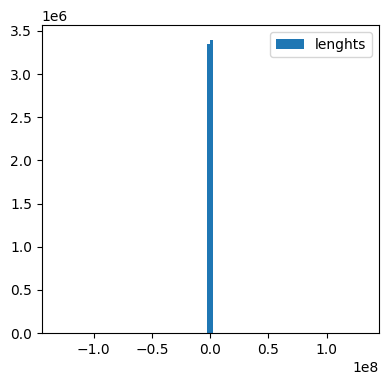

In [ ]:
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(1, 4, 1)

bam_file = pysam.AlignmentFile('/content/file.sorted.bam', 'rb')
template_lengths = [record.template_length for record in bam_file.fetch('chr11')]
bam_file.close()
lengths = np.array(template_lengths)
print(lengths)

ax.hist(lengths, label = 'lenghts', bins = 100)
ax.legend()

[ 232 -232  220 ... -136  205 -205]


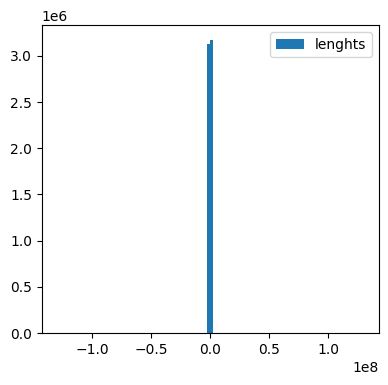

In [ ]:
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(1, 4, 1)

bam_file = pysam.AlignmentFile('/content/file.sorted.bam', 'rb')
template_lengths = [record.template_length for record in bam_file.fetch('chr11')]
bam_file.close()
lengths = np.array(template_lengths)
print(lengths)

ax.hist(lengths, label = 'lenghts', bins = 100)
ax.legend()

 Izvršiti obradu dobijenog BAM fajla prema GATK protokolu (Markiranje Duplikata, rekalibracija kvaliteta baza)


Markiranje duplikata

In [ ]:
ibam = 'file.sorted.bam'
obam = 'file.deduped.bam'

!java -jar picard.jar MarkDuplicates I={ibam} O={obam} M=dup_metrics.txt

!grep -A2 '## METRICS CLASS' dup_metrics.txt | grep -v '## METRICS CLASS' > report.tsv

INFO	2024-05-18 15:09:57	MarkDuplicates	

********** NOTE: Picard's command line syntax is changing.
**********
********** For more information, please see:
********** https://github.com/broadinstitute/picard/wiki/Command-Line-Syntax-Transition-For-Users-(Pre-Transition)
**********
********** The command line looks like this in the new syntax:
**********
**********    MarkDuplicates -I file.sorted.bam -O file.deduped.bam -M dup_metrics.txt
**********


15:09:59.369 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/content/picard.jar!/com/intel/gkl/native/libgkl_compression.so
[Sat May 18 15:09:59 UTC 2024] MarkDuplicates INPUT=[file.sorted.bam] OUTPUT=file.deduped.bam METRICS_FILE=dup_metrics.txt    MAX_SEQUENCES_FOR_DISK_READ_ENDS_MAP=50000 MAX_FILE_HANDLES_FOR_READ_ENDS_MAP=8000 SORTING_COLLECTION_SIZE_RATIO=0.25 TAG_DUPLICATE_SET_MEMBERS=false REMOVE_SEQUENCING_DUPLICATES=false TAGGING_POLICY=DontTag CLEAR_DT=true DUPLEX_UMI=false ADD_PG_TAG_TO_READS=true REMO

In [ ]:
ibam = 'file.sorted.bam'
obam = 'file.deduped.bam'

!java -jar picard.jar MarkDuplicates I={ibam} O={obam} M=dup_metrics.txt

!grep -A2 '## METRICS CLASS' dup_metrics.txt | grep -v '## METRICS CLASS' > report.tsv

INFO	2024-05-20 16:43:29	MarkDuplicates	

********** NOTE: Picard's command line syntax is changing.
**********
********** For more information, please see:
********** https://github.com/broadinstitute/picard/wiki/Command-Line-Syntax-Transition-For-Users-(Pre-Transition)
**********
********** The command line looks like this in the new syntax:
**********
**********    MarkDuplicates -I file.sorted.bam -O file.deduped.bam -M dup_metrics.txt
**********


16:43:30.371 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/content/picard.jar!/com/intel/gkl/native/libgkl_compression.so
[Mon May 20 16:43:30 UTC 2024] MarkDuplicates INPUT=[file.sorted.bam] OUTPUT=file.deduped.bam METRICS_FILE=dup_metrics.txt    MAX_SEQUENCES_FOR_DISK_READ_ENDS_MAP=50000 MAX_FILE_HANDLES_FOR_READ_ENDS_MAP=8000 SORTING_COLLECTION_SIZE_RATIO=0.25 TAG_DUPLICATE_SET_MEMBERS=false REMOVE_SEQUENCING_DUPLICATES=false TAGGING_POLICY=DontTag CLEAR_DT=true DUPLEX_UMI=false ADD_PG_TAG_TO_READS=true REMO

3a. Koliki su procenati PCR i optičkih duplikata?

In [ ]:
pd.read_csv('report.tsv', sep='\t')

,LIBRARY,UNPAIRED_READS_EXAMINED,READ_PAIRS_EXAMINED,SECONDARY_OR_SUPPLEMENTARY_RDS,UNMAPPED_READS,UNPAIRED_READ_DUPLICATES,READ_PAIR_DUPLICATES,READ_PAIR_OPTICAL_DUPLICATES,PERCENT_DUPLICATION,ESTIMATED_LIBRARY_SIZE
0,Unknown Library,20262,3365327,7883,178370,12159,235793,0,0.071656,22880221


In [ ]:
pd.read_csv('report.tsv', sep='\t')

,LIBRARY,UNPAIRED_READS_EXAMINED,READ_PAIRS_EXAMINED,SECONDARY_OR_SUPPLEMENTARY_RDS,UNMAPPED_READS,UNPAIRED_READ_DUPLICATES,READ_PAIR_DUPLICATES,READ_PAIR_OPTICAL_DUPLICATES,PERCENT_DUPLICATION,ESTIMATED_LIBRARY_SIZE
0,Unknown Library,22201,3203310,6891,225921,12744,214097,0,0.068588,22883784


Rekalibracija kvaliteta baza

In [ ]:
ibam = '/content/file.deduped.bam'
obam = 'file.recalibrated.bam'
recal = 'file.recal.table'

dbsnp = '/content/v0/Homo_sapiens_assembly38.dbsnp138.vcf'
ref = '/content/v0/Homo_sapiens_assembly38.fasta'

gatk = 'java -jar gatk-4.1.4.1/gatk-package-4.1.4.1-local.jar'

In [ ]:
!{gatk} BaseRecalibrator -I {ibam} --known-sites {dbsnp} -O {recal} --reference {ref}
!{gatk} ApplyBQSR -I {ibam} -bqsr {recal} -O {obam}
post_recal = 'file.post_recal.table'
!{gatk} BaseRecalibrator -I {obam} --known-sites {dbsnp} -O {post_recal} --reference {ref}
!{gatk} AnalyzeCovariates -before {recal} -after {post_recal} -plots 'compare.pdf'

15:14:01.945 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/content/gatk-4.1.4.1/gatk-package-4.1.4.1-local.jar!/com/intel/gkl/native/libgkl_compression.so
15:14:02.831 INFO  BaseRecalibrator - ------------------------------------------------------------
15:14:02.835 INFO  BaseRecalibrator - The Genome Analysis Toolkit (GATK) v4.1.4.1
15:14:02.835 INFO  BaseRecalibrator - For support and documentation go to https://software.broadinstitute.org/gatk/
15:14:02.837 INFO  BaseRecalibrator - Executing as root@488e65c76122 on Linux v6.1.85+ amd64
15:14:02.839 INFO  BaseRecalibrator - Java runtime: OpenJDK 64-Bit Server VM v11.0.22+7-post-Ubuntu-0ubuntu222.04.1
15:14:02.839 INFO  BaseRecalibrator - Start Date/Time: May 18, 2024 at 3:14:01 PM UTC
15:14:02.840 INFO  BaseRecalibrator - ------------------------------------------------------------
15:14:02.840 INFO  BaseRecalibrator - ------------------------------------------------------------
15:14:02.842 INFO  BaseRecal

In [ ]:
ibam = '/content/file.deduped.bam'
obam = 'file.recalibrated.bam'
recal = 'file.recal.table'

dbsnp = '/content/v0/Homo_sapiens_assembly38.dbsnp138.vcf'
ref = '/content/v0/Homo_sapiens_assembly38.fasta'

gatk = 'java -jar gatk-4.1.4.1/gatk-package-4.1.4.1-local.jar'

In [ ]:
!{gatk} BaseRecalibrator -I {ibam} --known-sites {dbsnp} -O {recal} --reference {ref}
!{gatk} ApplyBQSR -I {ibam} -bqsr {recal} -O {obam}
post_recal = 'file.post_recal.table'
!{gatk} BaseRecalibrator -I {obam} --known-sites {dbsnp} -O {post_recal} --reference {ref}
!{gatk} AnalyzeCovariates -before {recal} -after {post_recal} -plots 'compare.pdf'

16:46:26.888 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/content/gatk-4.1.4.1/gatk-package-4.1.4.1-local.jar!/com/intel/gkl/native/libgkl_compression.so
16:46:27.320 INFO  BaseRecalibrator - ------------------------------------------------------------
16:46:27.320 INFO  BaseRecalibrator - The Genome Analysis Toolkit (GATK) v4.1.4.1
16:46:27.320 INFO  BaseRecalibrator - For support and documentation go to https://software.broadinstitute.org/gatk/
16:46:27.321 INFO  BaseRecalibrator - Executing as root@5770d1467d56 on Linux v6.1.85+ amd64
16:46:27.321 INFO  BaseRecalibrator - Java runtime: OpenJDK 64-Bit Server VM v11.0.22+7-post-Ubuntu-0ubuntu222.04.1
16:46:27.322 INFO  BaseRecalibrator - Start Date/Time: May 20, 2024 at 4:46:26 PM UTC
16:46:27.322 INFO  BaseRecalibrator - ------------------------------------------------------------
16:46:27.322 INFO  BaseRecalibrator - ------------------------------------------------------------
16:46:27.323 INFO  BaseRecal

Identifikovati mutacije upotrebom alata Haplotype Caller i filtirtati mutacije predefinisanim filterima (hard filtering) prema Broad preporukama (kao što je rađeno na vežbama).

In [ ]:
gatk = 'java -jar gatk-4.1.4.1/gatk-package-4.1.4.1-local.jar'
dbsnp = '/content/v0/Homo_sapiens_assembly38.dbsnp138.vcf'
ref = '/content/v0/Homo_sapiens_assembly38.fasta'

ibam = '/content/file.recalibrated.bam'
ovcf = 'file.vcf'

!{gatk} HaplotypeCaller --input {ibam} --output {ovcf} --reference {ref} --dbsnp {dbsnp} -L chr11

15:31:47.314 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/content/gatk-4.1.4.1/gatk-package-4.1.4.1-local.jar!/com/intel/gkl/native/libgkl_compression.so
15:31:48.296 INFO  HaplotypeCaller - ------------------------------------------------------------
15:31:48.297 INFO  HaplotypeCaller - The Genome Analysis Toolkit (GATK) v4.1.4.1
15:31:48.297 INFO  HaplotypeCaller - For support and documentation go to https://software.broadinstitute.org/gatk/
15:31:48.298 INFO  HaplotypeCaller - Executing as root@488e65c76122 on Linux v6.1.85+ amd64
15:31:48.298 INFO  HaplotypeCaller - Java runtime: OpenJDK 64-Bit Server VM v11.0.22+7-post-Ubuntu-0ubuntu222.04.1
15:31:48.299 INFO  HaplotypeCaller - Start Date/Time: May 18, 2024 at 3:31:47 PM UTC
15:31:48.299 INFO  HaplotypeCaller - ------------------------------------------------------------
15:31:48.299 INFO  HaplotypeCaller - ------------------------------------------------------------
15:31:48.303 INFO  HaplotypeCaller -

In [ ]:
gatk = 'java -jar gatk-4.1.4.1/gatk-package-4.1.4.1-local.jar'
dbsnp = '/content/v0/Homo_sapiens_assembly38.dbsnp138.vcf'
ref = '/content/v0/Homo_sapiens_assembly38.fasta'

ibam = '/content/file.recalibrated.bam'
ovcf = 'file.vcf'

!{gatk} HaplotypeCaller --input {ibam} --output {ovcf} --reference {ref} --dbsnp {dbsnp} -L chr11

16:56:15.874 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/content/gatk-4.1.4.1/gatk-package-4.1.4.1-local.jar!/com/intel/gkl/native/libgkl_compression.so
16:56:16.272 INFO  HaplotypeCaller - ------------------------------------------------------------
16:56:16.273 INFO  HaplotypeCaller - The Genome Analysis Toolkit (GATK) v4.1.4.1
16:56:16.273 INFO  HaplotypeCaller - For support and documentation go to https://software.broadinstitute.org/gatk/
16:56:16.273 INFO  HaplotypeCaller - Executing as root@5770d1467d56 on Linux v6.1.85+ amd64
16:56:16.273 INFO  HaplotypeCaller - Java runtime: OpenJDK 64-Bit Server VM v11.0.22+7-post-Ubuntu-0ubuntu222.04.1
16:56:16.274 INFO  HaplotypeCaller - Start Date/Time: May 20, 2024 at 4:56:15 PM UTC
16:56:16.274 INFO  HaplotypeCaller - ------------------------------------------------------------
16:56:16.274 INFO  HaplotypeCaller - ------------------------------------------------------------
16:56:16.275 INFO  HaplotypeCaller -

In [ ]:
snp_f = "QD < 2.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0"
indel_f = "QD < 2.0 || FS > 200.0 || ReadPosRankSum < -20.0"

ref = '/content/v0/Homo_sapiens_assembly38.fasta'

ivcf = '/content/file.vcf'
isvcf = 'file.snp.vcf'
iivcf = 'file.indel.vcf'


osvcf = 'file.snp.filtered.vcf'
oivcf = 'file.indel.filtered.vcf'
ovcf = 'file.filtered.vcf'

In [ ]:
!{gatk} SelectVariants -R {ref} -V {ivcf} -O {isvcf} --select-type-to-include SNP
!{gatk} VariantFiltration -R {ref} -V {isvcf} -O {osvcf} -filter "{snp_f}" --filter-name "snp"

!{gatk} SelectVariants -R {ref} -V {ivcf} -O {iivcf} --select-type-to-include INDEL
!{gatk} VariantFiltration -R {ref} -V {iivcf} -O {oivcf} -filter "{indel_f}" --filter-name "indel"

!{gatk} MergeVcfs -I {osvcf} -I {oivcf} -O {ovcf}

Streaming output truncated to the last 5000 lines.
15:53:46.306 WARN  JexlEngine - ![38,47]: 'QD < 2.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0;' undefined variable MQRankSum
15:53:46.306 WARN  JexlEngine - ![38,47]: 'QD < 2.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0;' undefined variable MQRankSum
15:53:46.307 WARN  JexlEngine - ![38,47]: 'QD < 2.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0;' undefined variable MQRankSum
15:53:46.307 WARN  JexlEngine - ![38,47]: 'QD < 2.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0;' undefined variable MQRankSum
15:53:46.370 WARN  JexlEngine - ![38,47]: 'QD < 2.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0;' undefined variable MQRankSum
15:53:46.370 WARN  JexlEngine - ![38,47]: 'QD < 2.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0;' undefined variable MQRankSum
15:53:46.370 WARN  

In [ ]:
snp_f = "QD < 2.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0"
indel_f = "QD < 2.0 || FS > 200.0 || ReadPosRankSum < -20.0"

ref = '/content/v0/Homo_sapiens_assembly38.fasta'

ivcf = '/content/file.vcf'
isvcf = 'file.snp.vcf'
iivcf = 'file.indel.vcf'


osvcf = 'file.snp.filtered.vcf'
oivcf = 'file.indel.filtered.vcf'
ovcf = 'file.filtered.vcf'

In [ ]:
!{gatk} SelectVariants -R {ref} -V {ivcf} -O {isvcf} --select-type-to-include SNP
!{gatk} VariantFiltration -R {ref} -V {isvcf} -O {osvcf} -filter "{snp_f}" --filter-name "snp"

!{gatk} SelectVariants -R {ref} -V {ivcf} -O {iivcf} --select-type-to-include INDEL
!{gatk} VariantFiltration -R {ref} -V {iivcf} -O {oivcf} -filter "{indel_f}" --filter-name "indel"

!{gatk} MergeVcfs -I {osvcf} -I {oivcf} -O {ovcf}

Streaming output truncated to the last 5000 lines.
17:19:22.896 WARN  JexlEngine - ![38,47]: 'QD < 2.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0;' undefined variable MQRankSum
17:19:22.897 WARN  JexlEngine - ![38,47]: 'QD < 2.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0;' undefined variable MQRankSum
17:19:22.897 WARN  JexlEngine - ![38,47]: 'QD < 2.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0;' undefined variable MQRankSum
17:19:22.897 WARN  JexlEngine - ![38,47]: 'QD < 2.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0;' undefined variable MQRankSum
17:19:22.897 WARN  JexlEngine - ![38,47]: 'QD < 2.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0;' undefined variable MQRankSum
17:19:22.897 WARN  JexlEngine - ![38,47]: 'QD < 2.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0;' undefined variable MQRankSum
17:19:22.897 WARN  

In [ ]:
def is_filtered(variant):
  return 'PASS' not in variant.filter

def is_snp(variant):
  return len(variant.ref) == 1 and len(variant.alts[0]) == 1

def is_transitions(variant):
  allels = set((variant.ref, variant.alts[0]))
  return allels == {'A', 'G'} or allels == {'C', 'T'}

In [ ]:
def is_filtered(variant):
  return 'PASS' not in variant.filter

def is_snp(variant):
  return len(variant.ref) == 1 and len(variant.alts[0]) == 1

def is_transitions(variant):
  allels = set((variant.ref, variant.alts[0]))
  return allels == {'A', 'G'} or allels == {'C', 'T'}

4a. Koliko je ukupno mutacija identifikovano, koliko od njih su SNP-ovi, a koliko INDEL-i?

In [ ]:
ovcf = '/content/file.filtered.vcf'

print('SNPs:',
      sum(1 for v in pysam.VariantFile(ovcf) if is_filtered(v) and is_snp(v)))

print('INDELs:',
      sum(1 for v in pysam.VariantFile(ovcf) if is_filtered(v) and not is_snp(v)))

SNPs: 396
INDELs: 95


In [ ]:
ovcf = '/content/file.filtered.vcf'

print('SNPs:',
      sum(1 for v in pysam.VariantFile(ovcf) if is_filtered(v) and is_snp(v)))

print('INDELs:',
      sum(1 for v in pysam.VariantFile(ovcf) if is_filtered(v) and not is_snp(v)))

SNPs: 317
INDELs: 89


4b. Koliko mutacija prolazi, a koliko ne prolazi kriterijume filtriranja.

In [ ]:
ovcf = '/content/file.filtered.vcf'
print('Filtrirani:', sum(1 for v in pysam.VariantFile(ovcf) if is_filtered(v)))
print('Nefiltrirani:', sum(1 for v in pysam.VariantFile(ovcf) if not is_filtered(v)))

Filtrirani: 491
Nefiltrirani: 16244


In [ ]:
ovcf = '/content/file.filtered.vcf'
print('Filtrirani:', sum(1 for v in pysam.VariantFile(ovcf) if is_filtered(v)))
print('Nefiltrirani:', sum(1 for v in pysam.VariantFile(ovcf) if not is_filtered(v)))

Filtrirani: 406
Nefiltrirani: 16790


4c. Izračunati Ti/Tv odnos pre i posle filtriranja.

In [ ]:
x = '/content/file.vcf'

tinF = sum(1 for v in pysam.VariantFile(x) \
         if not is_filtered(v) \
         and is_snp(v)\
         and is_transitions(v))

tvnF = sum(1 for v in pysam.VariantFile(x) \
          if not is_filtered(v) \
          and is_snp(v) \
          and not is_transitions(v))

print('Ti:', tinF)
print('Tv:', tvnF)
print('Ti/Tv odnos pre filtriranja', tinF/tvnF)


tiF = sum(1 for v in pysam.VariantFile(ovcf) \
         if not is_filtered(v) \
         and is_snp(v)\
         and is_transitions(v))

tvF = sum(1 for v in pysam.VariantFile(ovcf) \
          if not is_filtered(v) \
          and is_snp(v) \
          and not is_transitions(v))

print('Ti:', tiF)
print('Tv:', tvF)
print('Ti/Tv odnos posle filtriranja', tiF/tvF)

Ti: 9836
Tv: 5077
Ti/Tv odnos pre filtriranja 1.9373645853850698
Ti: 9630
Tv: 4884
Ti/Tv odnos posle filtriranja 1.9717444717444716


In [ ]:
x = '/content/file.vcf'

tinF = sum(1 for v in pysam.VariantFile(x) \
         if not is_filtered(v) \
         and is_snp(v)\
         and is_transitions(v))

tvnF = sum(1 for v in pysam.VariantFile(x) \
          if not is_filtered(v) \
          and is_snp(v) \
          and not is_transitions(v))

print('Ti:', tinF)
print('Tv:', tvnF)
print('Ti/Tv odnos pre filtriranja', tinF/tvnF)


tiF = sum(1 for v in pysam.VariantFile(ovcf) \
         if not is_filtered(v) \
         and is_snp(v)\
         and is_transitions(v))

tvF = sum(1 for v in pysam.VariantFile(ovcf) \
          if not is_filtered(v) \
          and is_snp(v) \
          and not is_transitions(v))

print('Ti:', tiF)
print('Tv:', tvF)
print('Ti/Tv odnos posle filtriranja', tiF/tvF)

Ti: 9996
Tv: 5235
Ti/Tv odnos pre filtriranja 1.90945558739255
Ti: 9834
Tv: 5080
Ti/Tv odnos posle filtriranja 1.9358267716535433


Anotirati mutacije alatom Funcotator

In [ ]:
!{gatk} FuncotatorDataSourceDownloader --germline --extract-after-download

!cp "/content/drive/MyDrive/funcotator-funcotator_dataSources.v1.6.20190124g.tar.gz" .
!tar -xzf "funcotator-funcotator_dataSources.v1.6.20190124g.tar.gz"
ivcf = '/content/file.filtered.vcf'
ovcf = 'file.annotated.vcf'
func = 'funcotator_dataSources.v1.6.20190124g/'

!{gatk} Funcotator -O {ovcf} --ref-version hg38 -R {ref} -V {ivcf} --output-file-format VCF --data-sources-path {func}

reader = pysam.VariantFile(ovcf)
description = reader.header.info['FUNCOTATION'].description
print(description)
functotations = description[73:].split('|')

16:10:46.311 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/content/gatk-4.1.4.1/gatk-package-4.1.4.1-local.jar!/com/intel/gkl/native/libgkl_compression.so
16:10:46.881 INFO  FuncotatorDataSourceDownloader - ------------------------------------------------------------
16:10:46.882 INFO  FuncotatorDataSourceDownloader - The Genome Analysis Toolkit (GATK) v4.1.4.1
16:10:46.883 INFO  FuncotatorDataSourceDownloader - For support and documentation go to https://software.broadinstitute.org/gatk/
16:10:46.883 INFO  FuncotatorDataSourceDownloader - Executing as root@488e65c76122 on Linux v6.1.85+ amd64
16:10:46.883 INFO  FuncotatorDataSourceDownloader - Java runtime: OpenJDK 64-Bit Server VM v11.0.22+7-post-Ubuntu-0ubuntu222.04.1
16:10:46.884 INFO  FuncotatorDataSourceDownloader - Start Date/Time: May 18, 2024 at 4:10:46 PM UTC
16:10:46.885 INFO  FuncotatorDataSourceDownloader - ------------------------------------------------------------
16:10:46.885 INFO  Funcotator

In [ ]:
!wget -O gatk-4.1.4.1.zip "https://github.com/broadinstitute/gatk/releases/download/4.1.4.1/gatk-4.1.4.1.zip"
!unzip gatk-4.1.4.1.zip
!chmod +x gatk-4.1.4.1/gatk


In [ ]:
!wget ftp://gsapubftp-anonymous@ftp.broadinstitute.org/bundle/funcotator/funcotator_dataSources.v1.6.20190124g.tar.gz

In [ ]:
!tar -xzf funcotator_dataSources.v1.6.20190124g.tar.gz


In [ ]:
!{gatk} FuncotatorDataSourceDownloader --germline --extract-after-download

!cp "/content/drive/MyDrive/funcotator-funcotator_dataSources.v1.6.20190124g.tar.gz" .
!tar -xzf "funcotator-funcotator_dataSources.v1.6.20190124g.tar.gz"
ivcf = '/content/file.filtered.vcf'
ovcf = 'file.annotated.vcf'
func = 'funcotator_dataSources.v1.6.20190124g/'

!{gatk} Funcotator -O {ovcf} --ref-version hg38 -R {ref} -V {ivcf} --output-file-format VCF --data-sources-path {func}

reader = pysam.VariantFile(ovcf)
description = reader.header.info['FUNCOTATION'].description
print(description)
functotations = description[73:].split('|')

18:16:36.416 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/content/gatk-4.1.4.1/gatk-package-4.1.4.1-local.jar!/com/intel/gkl/native/libgkl_compression.so
18:16:36.612 INFO  FuncotatorDataSourceDownloader - ------------------------------------------------------------
18:16:36.613 INFO  FuncotatorDataSourceDownloader - The Genome Analysis Toolkit (GATK) v4.1.4.1
18:16:36.613 INFO  FuncotatorDataSourceDownloader - For support and documentation go to https://software.broadinstitute.org/gatk/
18:16:36.613 INFO  FuncotatorDataSourceDownloader - Executing as root@5770d1467d56 on Linux v6.1.85+ amd64
18:16:36.614 INFO  FuncotatorDataSourceDownloader - Java runtime: OpenJDK 64-Bit Server VM v11.0.22+7-post-Ubuntu-0ubuntu222.04.1
18:16:36.614 INFO  FuncotatorDataSourceDownloader - Start Date/Time: May 20, 2024 at 6:16:36 PM UTC
18:16:36.614 INFO  FuncotatorDataSourceDownloader - ------------------------------------------------------------
18:16:36.614 INFO  Funcotator

In [ ]:
print('\n'.join(functotations))

Gencode_27_hugoSymbol
Gencode_27_ncbiBuild
Gencode_27_chromosome
Gencode_27_start
Gencode_27_end
Gencode_27_variantClassification
Gencode_27_secondaryVariantClassification
Gencode_27_variantType
Gencode_27_refAllele
Gencode_27_tumorSeqAllele1
Gencode_27_tumorSeqAllele2
Gencode_27_genomeChange
Gencode_27_annotationTranscript
Gencode_27_transcriptStrand
Gencode_27_transcriptExon
Gencode_27_transcriptPos
Gencode_27_cDnaChange
Gencode_27_codonChange
Gencode_27_proteinChange
Gencode_27_gcContent
Gencode_27_referenceContext
Gencode_27_otherTranscripts
ACMGLMMLof_LOF_Mechanism
ACMGLMMLof_Mode_of_Inheritance
ACMGLMMLof_Notes
ACMG_recommendation_Disease_Name
ClinVar_VCF_AF_ESP
ClinVar_VCF_AF_EXAC
ClinVar_VCF_AF_TGP
ClinVar_VCF_ALLELEID
ClinVar_VCF_CLNDISDB
ClinVar_VCF_CLNDISDBINCL
ClinVar_VCF_CLNDN
ClinVar_VCF_CLNDNINCL
ClinVar_VCF_CLNHGVS
ClinVar_VCF_CLNREVSTAT
ClinVar_VCF_CLNSIG
ClinVar_VCF_CLNSIGCONF
ClinVar_VCF_CLNSIGINCL
ClinVar_VCF_CLNVC
ClinVar_VCF_CLNVCSO
ClinVar_VCF_CLNVI
ClinVar_VCF_D

In [ ]:
print('\n'.join(functotations))

Gencode_27_hugoSymbol
Gencode_27_ncbiBuild
Gencode_27_chromosome
Gencode_27_start
Gencode_27_end
Gencode_27_variantClassification
Gencode_27_secondaryVariantClassification
Gencode_27_variantType
Gencode_27_refAllele
Gencode_27_tumorSeqAllele1
Gencode_27_tumorSeqAllele2
Gencode_27_genomeChange
Gencode_27_annotationTranscript
Gencode_27_transcriptStrand
Gencode_27_transcriptExon
Gencode_27_transcriptPos
Gencode_27_cDnaChange
Gencode_27_codonChange
Gencode_27_proteinChange
Gencode_27_gcContent
Gencode_27_referenceContext
Gencode_27_otherTranscripts
ACMGLMMLof_LOF_Mechanism
ACMGLMMLof_Mode_of_Inheritance
ACMGLMMLof_Notes
ACMG_recommendation_Disease_Name
ClinVar_VCF_AF_ESP
ClinVar_VCF_AF_EXAC
ClinVar_VCF_AF_TGP
ClinVar_VCF_ALLELEID
ClinVar_VCF_CLNDISDB
ClinVar_VCF_CLNDISDBINCL
ClinVar_VCF_CLNDN
ClinVar_VCF_CLNDNINCL
ClinVar_VCF_CLNHGVS
ClinVar_VCF_CLNREVSTAT
ClinVar_VCF_CLNSIG
ClinVar_VCF_CLNSIGCONF
ClinVar_VCF_CLNSIGINCL
ClinVar_VCF_CLNVC
ClinVar_VCF_CLNVCSO
ClinVar_VCF_CLNVI
ClinVar_VCF_D

5a. Izbrojati različite vrednosti ClinVar značajnosti (anotacija ClinVar_VCF_CLNSIG, koliko mutacija je označeno kao Benign, Likely_benign, itd.).

In [ ]:
import io
import pysam

b = 0
lb = 0
b_lb = 0

encodings = ['utf-8', 'latin1', 'cp1252']

for encoding in encodings:
    try:
        with open(ovcf, 'r', encoding=encoding) as vcf_file:
            vcf_wrapper = io.TextIOWrapper(vcf_file, encoding=encoding)
            vcf_reader = pysam.VariantFile(vcf_wrapper)

            for variant in vcf_reader:
                ann = {x: y for x, y in zip(functotations, variant.info['FUNCOTATION'][0][1:-1].split('|'))}

                if ann['ClinVar_VCF_CLNSIG'] == 'Benign':
                    b += 1
                elif ann['ClinVar_VCF_CLNSIG'] == 'Likely_benign':
                    lb += 1
                elif ann['ClinVar_VCF_CLNSIG'] == 'Benign/Likely_benign':
                    b_lb += 1

        break  # Izlazimo iz petlje ako je uspešno otvoren i dekodiran fajl

    except UnicodeDecodeError:
        continue  # Pokušavamo sa sledećim enkodingom ako se javi UnicodeDecodeError

print('Benign:')
print(b)
print('Likely_benign:')
print(lb)
print('Benign/Likely_benign:')
print(b_lb)


Benign:
492
Likely_benign:
51
Benign/Likely_benign:
84


In [ ]:
import io
import pysam

b = 0
lb = 0
b_lb = 0

encodings = ['utf-8', 'latin1', 'cp1252']

for encoding in encodings:
    try:
        with open(ovcf, 'r', encoding=encoding) as vcf_file:
            vcf_wrapper = io.TextIOWrapper(vcf_file, encoding=encoding)
            vcf_reader = pysam.VariantFile(vcf_wrapper)

            for variant in vcf_reader:
                ann = {x: y for x, y in zip(functotations, variant.info['FUNCOTATION'][0][1:-1].split('|'))}

                if ann['ClinVar_VCF_CLNSIG'] == 'Benign':
                    b += 1
                elif ann['ClinVar_VCF_CLNSIG'] == 'Likely_benign':
                    lb += 1
                elif ann['ClinVar_VCF_CLNSIG'] == 'Benign/Likely_benign':
                    b_lb += 1

        break  # Izlazimo iz petlje ako je uspešno otvoren i dekodiran fajl

    except UnicodeDecodeError:
        continue  # Pokušavamo sa sledećim enkodingom ako se javi UnicodeDecodeError

print('Benign:')
print(b)
print('Likely_benign:')
print(lb)
print('Benign/Likely_benign:')
print(b_lb)


Benign:
435
Likely_benign:
33
Benign/Likely_benign:
57


Svi uzorici sadrže određenu količinu kontaminacije DNK materijalom bakterijskog ili virusnog porekla. Većina ovakvih readova se neće mapirati na ljudski genom. Izvući readove koji nisu mapirani u procesu mapiranja, asemblovati ih alatom abyss, i identifikovati organizam od kojeg potiče najduži skafold upotrebom alata Blast.

In [ ]:
!sudo apt-get install autotools-dev automake
!git clone https://github.com/bcgsc/abyss.git
!cd abyss && ./autogen.sh
!cd abyss && ./configure
!cd abyss && make
!cd abyss && sudo make install

!sudo apt-get install abyss

In [ ]:
!wget https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/2.10.0/setup-apt.sh
!sudo sh setup-apt.sh

In [ ]:
# Prazan FASTQ fajl
fastq_file = '/content/drive/MyDrive/novi.fastq'

# Otvaranje fajla u režimu pisanja
with open(fastq_file, 'w') as f:
    pass

# Potvrda završetka
print(f'Prazan FASTQ fajl {fastq_file} je uspešno generisan.')


Prazan FASTQ fajl /content/drive/MyDrive/novi.fastq je uspešno generisan.


In [ ]:
!pip install Bio

In [ ]:
from Bio import SeqIO
import pysam
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

In [ ]:
from Bio import SeqIO
import pysam

# Putanja do BAM fajla
bam_file = '/content/file.sorted.bam'

# Otvorite BAM fajl za čitanje
bam = pysam.AlignmentFile(bam_file, 'rb')

# Kreirajte praznu listu za čuvanje ne-mapiranih readova
unmapped_reads = []

# Iterirajte kroz svaki read u BAM fajlu
for read in bam.fetch():
    if read.is_unmapped:  # Proverite da li je read ne-mapiran
        unmapped_reads.append(read.query_sequence)

# Zatvorite BAM fajl
bam.close()

# Putanja do izlaznog FASTQ fajla
fastq_file = '/content/drive/MyDrive/novi.fastq'

# Kreiranje i čuvanje FASTQ zapisa za nemapirane readove
seq_records = []
for i, seq in enumerate(unmapped_reads):
    seq_record = SeqRecord(Seq(seq), id=f'read{i+1}', description='')
    seq_record.letter_annotations["phred_quality"] = [40] * len(seq)  # Postavljamo podrazumevanu vrednost kvaliteta
    seq_records.append(seq_record)

SeqIO.write(seq_records, fastq_file, 'fastq')


print(f'FASTQ fajl sa nemapiranim readovima je uspešno kreiran: {fastq_file}')


FASTQ fajl sa nemapiranim readovima je uspešno kreiran: /content/drive/MyDrive/novi.fastq


In [10]:
!abyss-pe name=chr11 k=64 in='/content/drive/MyDrive/bioinf/sample_9.chrom11.exome.pe1.fq /content/drive/MyDrive/bioinf/sample_9.chrom11.exome.pe2.fq'

ABYSS -k64 -q3    --coverage-hist=coverage.hist -s chr11-bubbles.fa  -o chr11-1.fa /content/drive/MyDrive/bioinf/sample_9.chrom11.exome.pe1.fq /content/drive/MyDrive/bioinf/sample_9.chrom11.exome.pe2.fq 
ABySS 2.3.1
ABYSS -k64 -q3 --coverage-hist=coverage.hist -s chr11-bubbles.fa -o chr11-1.fa /content/drive/MyDrive/bioinf/sample_9.chrom11.exome.pe1.fq /content/drive/MyDrive/bioinf/sample_9.chrom11.exome.pe2.fq
Reading `/content/drive/MyDrive/bioinf/sample_9.chrom11.exome.pe1.fq'...
`/content/drive/MyDrive/bioinf/sample_9.chrom11.exome.pe1.fq': discarded 161944 reads shorter than 64 bases
`/content/drive/MyDrive/bioinf/sample_9.chrom11.exome.pe1.fq': discarded 63 reads containing non-ACGT characters
Reading `/content/drive/MyDrive/bioinf/sample_9.chrom11.exome.pe2.fq'...
`/content/drive/MyDrive/bioinf/sample_9.chrom11.exome.pe2.fq': discarded 237507 reads shorter than 64 bases
`/content/drive/MyDrive/bioinf/sample_9.chrom11.exome.pe2.fq': discarded 640 reads containing non-ACGT charact

In [ ]:
!abyss-pe name=chr11 k=64 in='/content/drive/MyDrive/bioinf/sample_7.chrom11.exome.pe1.fq /content/drive/MyDrive/bioinf/sample_7.chrom11.exome.pe2.fq'

ABYSS -k64 -q3    --coverage-hist=coverage.hist -s chr11-bubbles.fa  -o chr11-1.fa /content/drive/MyDrive/bioinf/sample_7.chrom11.exome.pe1.fq /content/drive/MyDrive/bioinf/sample_7.chrom11.exome.pe2.fq 
ABySS 2.3.1
ABYSS -k64 -q3 --coverage-hist=coverage.hist -s chr11-bubbles.fa -o chr11-1.fa /content/drive/MyDrive/bioinf/sample_7.chrom11.exome.pe1.fq /content/drive/MyDrive/bioinf/sample_7.chrom11.exome.pe2.fq
Reading `/content/drive/MyDrive/bioinf/sample_7.chrom11.exome.pe1.fq'...
`/content/drive/MyDrive/bioinf/sample_7.chrom11.exome.pe1.fq': discarded 159458 reads shorter than 64 bases
`/content/drive/MyDrive/bioinf/sample_7.chrom11.exome.pe1.fq': discarded 1 reads containing non-ACGT characters
Reading `/content/drive/MyDrive/bioinf/sample_7.chrom11.exome.pe2.fq'...
`/content/drive/MyDrive/bioinf/sample_7.chrom11.exome.pe2.fq': discarded 235114 reads shorter than 64 bases
`/content/drive/MyDrive/bioinf/sample_7.chrom11.exome.pe2.fq': discarded 55 reads containing non-ACGT character

In [ ]:
import pysam

freader = pysam.FastaFile('/content/drive/MyDrive/novi.fastq')

list(zip(freader.lengths, freader.references))

max_ref = sorted(zip(freader.lengths, freader.references), reverse=True)[0]
max_ref

freader.fetch(max_ref[1])

'CCGCATGTCTGGCTGATGACCGACGACATGTACGAGCACCTCGTCCATGACGACTTCCAGTTCACCACGTTCGCGCAGGTCGAGCCGAAACTCTACGACCGGACGCTCACCGTGAGCGGCGTGTCGAAGGCCTATTGCATGACAGGCTGGCGCTTCGGCTAGGCCGGCGGTAGGACGAAGCGCATCCAGGACAAGTAAACGATCCAGTCGCAGTCGCACGCGAAGCCGACGTTGATTGGACAAAGGGCCGGGTCGGAAGAGCTGAAGGGTCCGCCTGACTTCATCCCCGCCAACAACAAGG'

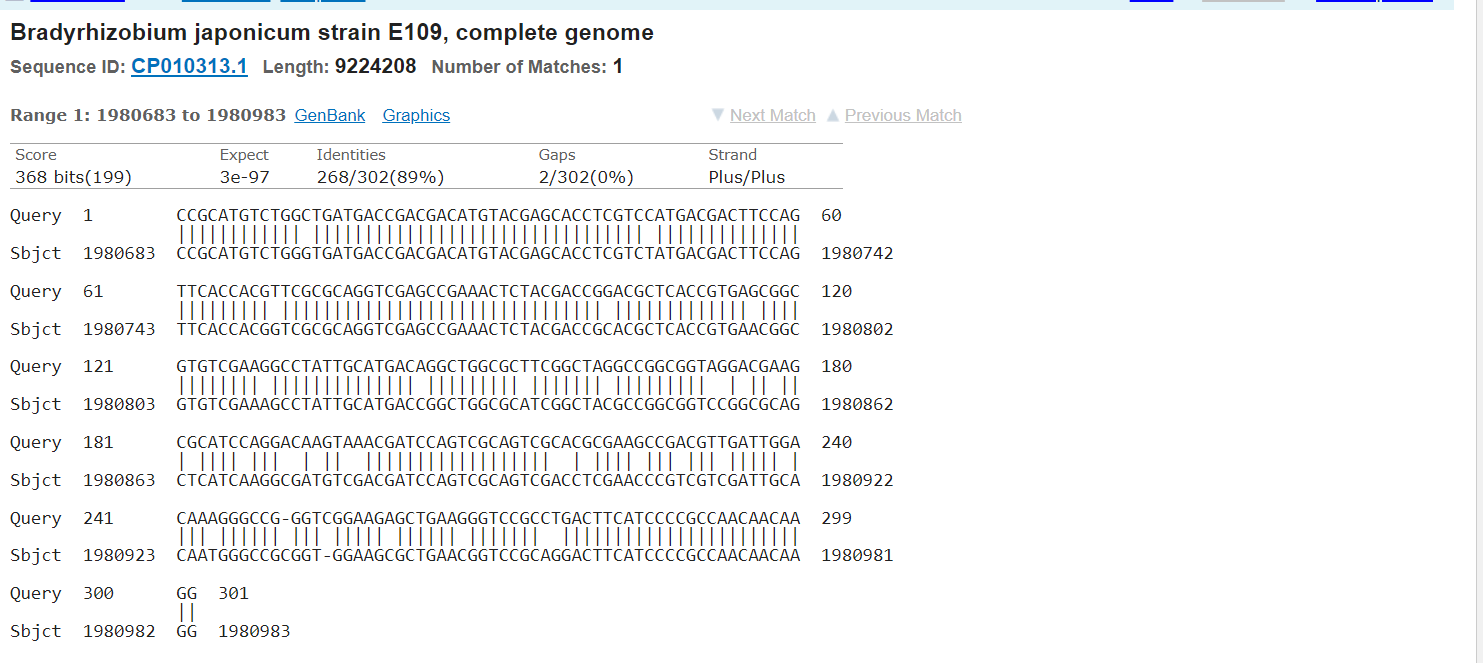

In [ ]:
import pysam
print('Sample7: ')

freader = pysam.FastaFile('/content/drive/MyDrive/novi.fastq')

list(zip(freader.lengths, freader.references))

max_ref = sorted(zip(freader.lengths, freader.references), reverse=True)[0]
max_ref

freader.fetch(max_ref[1])

Sample7: 


'GGTTAAAGGGTGTGTTGGATGCCCCTCTGGTACCAAGCTCTCAGAACTGTCTCTTATACACATCTGACGCTGCCGACGATCTTACGCGTGTAGATCTCGGTGGTCGCCGTATCATTAAAAAAAAAGGGGGGGGGGGGGGGGGGGGGGGGGG'

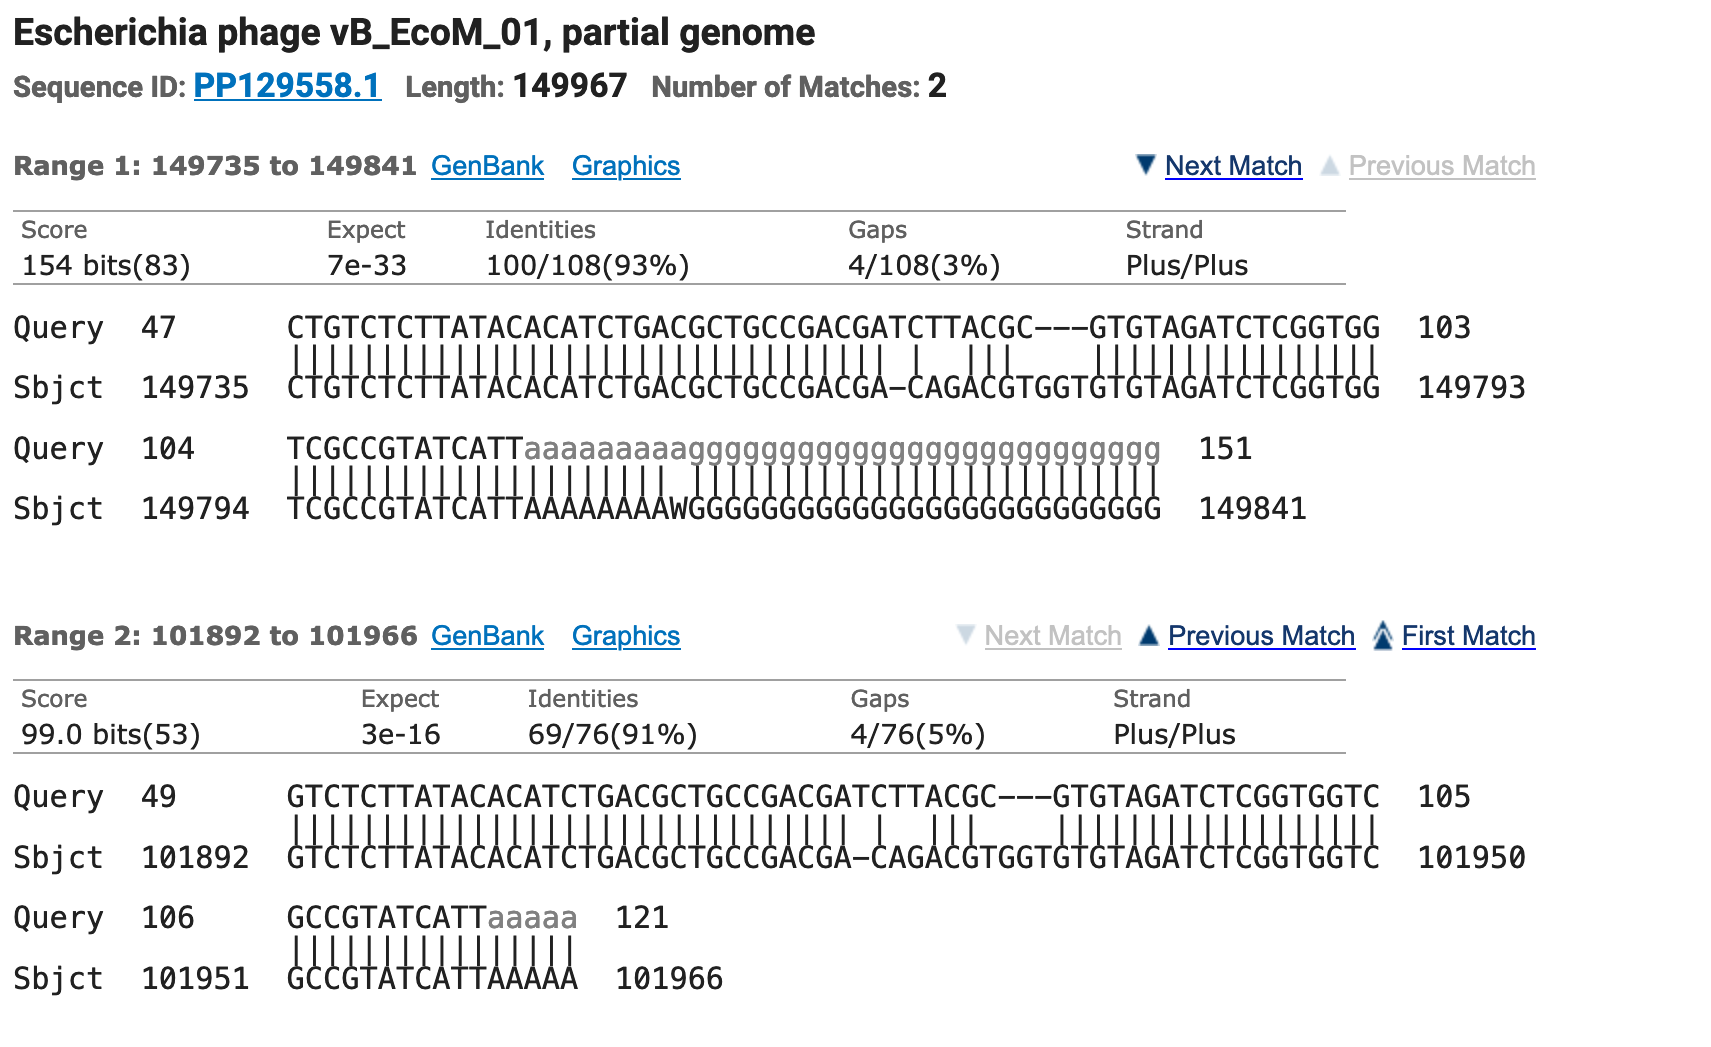